In [1]:
import torch as t
t.set_num_threads(8)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from train import train
from models import Transformer, Low_rank, AoT
from utils import generate_data, entropy, power_unif_law
from tqdm import tqdm

100%|██████████| 4/4 [00:11<00:00,  2.99s/it]


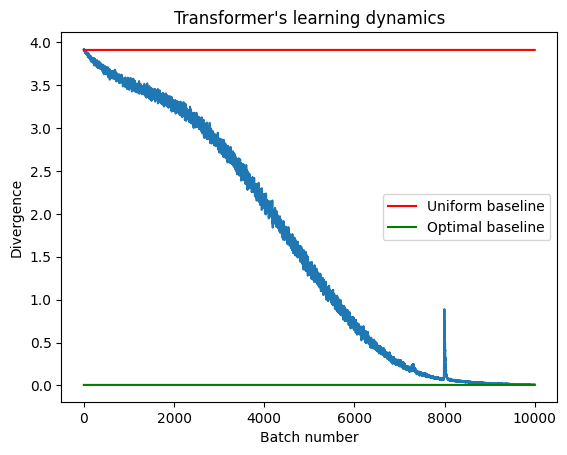

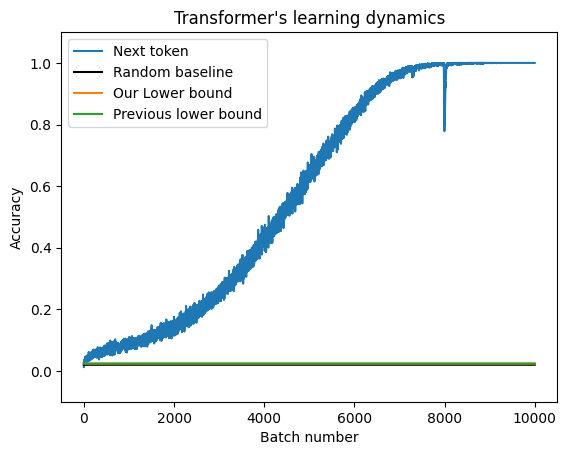

In [3]:
"""Training Transformer."""

# Transformer parameters.
N = 50
d = 10
nb_layers = 1
width = 2000
depth = 1
para = 1
d_head = 10
nb_head = 1
n_gram = 3
context_window = n_gram

# Distribution parameters.
alphas = [1, 1, 1]
nb_tokens=[N, N, 1]
t.manual_seed(2222)
pi = power_unif_law(alphas, nb_tokens, N)

# Learning parameters for the Transformer.
batch_size=2**10
num_batch=1000
epoches=10
lr=1e-3
Data = generate_data(batch_size=batch_size, num_batch=num_batch, pi=pi, context_window=context_window)

# Training the Transformer.
model = Transformer(d, N, nb_layers, width, depth, para, d_head, nb_head, context_window, pi)
Dict = train(model, Data, epoches, lr=lr, next_token=True)
plt.plot(Dict['Loss'])

# Upper bound: we compute the divergence with the uniform predictor.
ent=entropy(pi)
plt.plot([np.log(N)-ent for _ in Dict['Loss']], label='Uniform baseline', color='red')

# Learning parameters for the sequence encoder.
low_batch_size=2**10
low_num_batch=1000
low_lr=1e-3
epochs=4

# Lower bound: we compute the best Sequence encoder, the diverge of which sets the attainable lower bound.
model_low = Low_rank(d, N, context_window, pi)
Data = generate_data(low_batch_size, low_num_batch, pi, context_window)
dict_low = train(model_low, Data, epochs, lr=low_lr)
best_loss = sum(dict_low['Loss'][-101:-1])/100
plt.plot([best_loss for _ in Dict['Loss']], label='Optimal baseline', color='green')

plt.legend()
plt.xlabel("Batch number")
plt.ylabel("Divergence")
plt.title("Transformer's learning dynamics")
plt.show()

# We plot the accuracy of the Transformer, the accuracy of the random predictor, 
# and the lower bound from are paper as well as the previous sota bound (in accuracy, not in worst-case).
plt.plot(Dict['Acc'], label=f'Next token')
plt.plot([1/N for _ in Dict['Acc']], color='black', label='Random baseline')
plt.plot([1/N+(1-1/N)*para*d_head/(N**(n_gram-1)) for _ in Dict['Acc']], label='Our Lower bound')
plt.plot([1/N+(1-1/N)*(para*(d_head-1)+1)/(N**(n_gram-1)) for _ in Dict['Acc']], label='Previous lower bound')

plt.legend()
plt.xlabel("Batch number")
plt.ylabel("Accuracy")
plt.ylim(top=1+0.1, bottom=0-0.1)
plt.title("Transformer's learning dynamics")
plt.show()

In [ ]:
"""Scaling laws for the Memorization Capacity of an AoT."""

# Choice of the experiment: 
# - 1 for the case d=d_head, 
# - 2 for the case d fixed, 
# - 3 for the case d_head fixed,
exp_number = 2
if exp_number == 1:
    parameter_list = [(50, d, d, 31, 1, 5) for d in range(3, 13+1)]
elif exp_number == 2:
    parameter_list = [(50, 10, d_head, 8, 5, 3) for d_head in [10, 11, 12, 13, 15, 16]]
elif exp_number == 3:
    parameter_list = [(50, d, 10, 21, 5, 4) for d in range(5, 15+1, 2)]
elif exp_number == 4:
    parameter_list = [(10, 10, 2*20*10, 1*2*10, 20)]

# Model parameters.
nb_layers = 1
nb_head = 1
n_gram = 3
context_window = n_gram

# Distribution parameters.
alphas = [1, 1, 1]
nb_tokens=[100, 100, 1]

# Training parameters.
batch_size=2**9
num_batch=1000
lr=1e-3
epochs=20

repetition = 2

N = 50
t.manual_seed(2222)
pi = power_unif_law(alphas, nb_tokens, N)
Data = generate_data(batch_size=batch_size, num_batch=num_batch, pi=pi, context_window=context_window)
for i, (N, d, d_head, max_para, min_para, step) in enumerate(parameter_list):
    
    mean_accuracy = []
    para_list = []
    N_list = []
    d_list = []
    d_head_list = []
    width_list = []

    for para in tqdm(range(min_para, max_para+1, step)):
        accuracy = 0

        for _ in range(repetition):
            if exp_number == 4:
                width = para
                model = Transformer(d, N, nb_layers, width, 1, 1, d_head, nb_head, context_window, pi)
            else:
                model = AoT(d, N, nb_layers, para, d_head, nb_head, context_window, pi)

            dict = train(model, Data, epochs, lr=lr, next_token=True)
            acc = sum(dict['Acc'][-101:-1])/100
            
            accuracy += acc

        mean_accuracy.append(accuracy/repetition)
        N_list.append(N)
        d_list.append(d)
        d_head_list.append(d_head)
        if exp_number == 4:
            width_list.append(width)
            para_list.append(1)
        else:
            para_list.append(para)
            width_list.append(0)

    results = {
        'acc': mean_accuracy,
        'para': para_list,
        'N': N_list,
        'd': d_list,
        'd_head': d_head_list,
        'width': width_list,
    }

    # We save the results as a dataframe.
    data = pd.DataFrame(results)
    data.to_csv(f'Scaling laws/Exp_{6+i}_{exp_number}.csv', index=False)

In [5]:
"""Scaling laws for the Memorization Capacity of an AoT."""

# Choice of the experiment: 
# - 1 for the case d=d_head, 
# - 2 for the case d fixed, 
# - 3 for the case d_head fixed,
exp_number = 2
min_d_head = 5
max_d_head = 15
step = 1

# Model parameters.
nb_layers = 1
nb_head = 1
n_gram = 3
context_window = n_gram

# Distribution parameters.
alphas = [1, 1, 1]
nb_tokens=[100, 100, 1]

# Training parameters.
batch_size=2**10
num_batch=1000
lr=1e-3
epochs=10

repetition = 2

N = 50
d = 10
para = 20
t.manual_seed(2222)
pi = power_unif_law(alphas, nb_tokens, N)
Data = generate_data(batch_size=batch_size, num_batch=num_batch, pi=pi, context_window=context_window)

mean_accuracy = []
para_list = []
N_list = []
d_list = []
d_head_list = []

for d_head in tqdm(range(min_d_head, max_d_head+1, step)):
    accuracy = 0

    for _ in range(repetition):
        model = AoT(d, N, nb_layers, para, d_head, nb_head, context_window, pi)

        dict = train(model, Data, epochs, lr=lr, next_token=True)
        acc = sum(dict['Acc'][-101:-1])/100
            
        accuracy += acc
        print(accuracy)

    mean_accuracy.append(accuracy/repetition)
    N_list.append(N)
    d_list.append(d)
    d_head_list.append(d_head)
    para_list.append(para)

results = {
    'acc': mean_accuracy,
    'para': para_list,
    'N': N_list,
    'd': d_list,
    'd_head': d_head_list,
}

# We save the results as a dataframe.
data = pd.DataFrame(results)
data.to_csv(f'Scaling laws/Exp_{-1}_{exp_number}.csv', index=False)

100%|██████████| 10/10 [02:40<00:00, 16.04s/it]


0.23080078125


  9%|▉         | 1/11 [05:16<52:49, 316.91s/it]

0.440439453125


100%|██████████| 10/10 [02:55<00:00, 17.55s/it]


0.280224609375


 18%|█▊        | 2/11 [11:10<50:43, 338.20s/it]

0.56044921875


100%|██████████| 10/10 [02:59<00:00, 18.00s/it]


0.367734375


 27%|██▋       | 3/11 [17:09<46:22, 347.80s/it]

0.73546875


100%|██████████| 10/10 [03:04<00:00, 18.48s/it]


0.46947265625


 36%|███▋      | 4/11 [23:18<41:33, 356.17s/it]

0.9389453125


100%|██████████| 10/10 [03:16<00:00, 19.69s/it]


0.55154296875


 45%|████▌     | 5/11 [29:51<36:58, 369.73s/it]

1.1030859375


100%|██████████| 10/10 [03:21<00:00, 20.11s/it]


0.671240234375


 55%|█████▍    | 6/11 [36:35<31:46, 381.33s/it]

1.34248046875


100%|██████████| 10/10 [03:29<00:00, 20.90s/it]


0.769296875


 64%|██████▎   | 7/11 [43:34<26:13, 393.41s/it]

1.53859375


100%|██████████| 10/10 [03:49<00:00, 22.90s/it]


0.836484375


 73%|███████▎  | 8/11 [50:56<20:27, 409.13s/it]

1.67296875


100%|██████████| 10/10 [03:45<00:00, 22.60s/it]


0.812890625


 82%|████████▏ | 9/11 [58:30<14:06, 423.08s/it]

1.62578125


100%|██████████| 10/10 [03:55<00:00, 23.57s/it]


0.846923828125


 91%|█████████ | 10/11 [1:06:30<07:20, 440.50s/it]

1.69384765625


100%|██████████| 10/10 [03:49<00:00, 22.99s/it]


0.88603515625


100%|██████████| 11/11 [1:14:03<00:00, 403.94s/it]

1.7720703125


In [9]:
"""Scaling laws for the Memorization Capacity of an AoT."""

# Choice of the experiment: 
# - 1 for the case d=d_head, 
# - 2 for the case d fixed, 
# - 3 for the case d_head fixed,
exp_number = 3
min_d = 5
max_d = 25
step = 1

# Model parameters.
nb_layers = 1
nb_head = 1
n_gram = 3
context_window = n_gram

# Distribution parameters.
alphas = [1, 1, 1]
nb_tokens=[100, 100, 1]

# Training parameters.
batch_size=2**10
num_batch=1000
lr=1e-3
epochs=10

repetition = 1

N = 50
d_head = 10
para = 20
t.manual_seed(3333)
pi = power_unif_law(alphas, nb_tokens, N)
Data = generate_data(batch_size=batch_size, num_batch=num_batch, pi=pi, context_window=context_window)

mean_accuracy = []
para_list = []
N_list = []
d_list = []
d_head_list = []

for d in tqdm(range(min_d, max_d+1, step)):
    accuracy = 0

    for _ in range(repetition):
        model = AoT(d, N, nb_layers, para, d_head, nb_head, context_window, pi)

        dict = train(model, Data, epochs, lr=lr, next_token=True)
        acc = sum(dict['Acc'][-101:-1])/100
            
        accuracy += acc
        print(accuracy)

    mean_accuracy.append(accuracy/repetition)
    N_list.append(N)
    d_list.append(d)
    d_head_list.append(d_head)
    para_list.append(para)

results = {
    'acc': mean_accuracy,
    'para': para_list,
    'N': N_list,
    'd': d_list,
    'd_head': d_head_list,
}

# We save the results as a dataframe.
data = pd.DataFrame(results)
data.to_csv(f'Scaling laws/Data_exp_3.csv', index=False)

  5%|▍         | 1/21 [03:21<1:07:15, 201.79s/it]

0.247900390625


 10%|▉         | 2/21 [15:33<2:42:40, 513.70s/it]

0.313310546875


 14%|█▍        | 3/21 [18:57<1:51:37, 372.07s/it]

0.4316015625


 19%|█▉        | 4/21 [22:21<1:26:40, 305.89s/it]

0.49224609375


 24%|██▍       | 5/21 [25:56<1:12:49, 273.09s/it]

0.679794921875


 29%|██▊       | 6/21 [29:31<1:03:19, 253.27s/it]

0.651416015625


 33%|███▎      | 7/21 [32:58<55:36, 238.29s/it]  

0.720439453125


 38%|███▊      | 8/21 [36:19<48:59, 226.13s/it]

0.7097265625


 43%|████▎     | 9/21 [39:44<43:54, 219.58s/it]

0.723876953125


 48%|████▊     | 10/21 [43:07<39:20, 214.62s/it]

0.755556640625


 52%|█████▏    | 11/21 [46:34<35:23, 212.34s/it]

0.728798828125


 57%|█████▋    | 12/21 [49:56<31:21, 209.07s/it]

0.7208984375


 62%|██████▏   | 13/21 [54:41<30:57, 232.18s/it]

0.7514453125


 67%|██████▋   | 14/21 [59:49<29:45, 255.08s/it]

0.789599609375


 71%|███████▏  | 15/21 [1:05:05<27:20, 273.40s/it]

0.781748046875


 76%|███████▌  | 16/21 [1:10:41<24:20, 292.10s/it]

0.81865234375


 81%|████████  | 17/21 [1:15:38<19:34, 293.52s/it]

0.772021484375


 86%|████████▌ | 18/21 [1:20:47<14:54, 298.25s/it]

0.80916015625


 90%|█████████ | 19/21 [1:26:04<10:07, 303.80s/it]

0.772255859375


 95%|█████████▌| 20/21 [1:31:09<05:04, 304.26s/it]

0.804462890625


100%|██████████| 21/21 [1:35:35<00:00, 273.10s/it]

0.830380859375


In [5]:
"""Scaling laws for the Memorization Capacity of an AoT."""

# Choice of the experiment: 
# - 1 for the case d=d_head, 
# - 2 for the case d fixed, 
# - 3 for the case d_head fixed,
exp_number = 5
min_width = 2*10*1
max_width = 2*10*26
step = 2*10*5

# Model parameters.
nb_layers = 1
nb_head = 1
n_gram = 3
context_window = n_gram

# Distribution parameters.
alphas = [1, 1, 1]
nb_tokens=[100, 100, 1]

# Training parameters.
batch_size=2**10
num_batch=1000
lr=1e-3
epochs=10

repetition = 1

N = 50
d = 5
d_head = d
para = 1
t.manual_seed(3333)
pi = power_unif_law(alphas, nb_tokens, N)
Data = generate_data(batch_size=batch_size, num_batch=num_batch, pi=pi, context_window=context_window)

mean_accuracy = []
para_list = []
N_list = []
d_list = []
d_head_list = []
width_list = []

for width in tqdm(range(min_width, max_width+1, step)):
    accuracy = 0

    for _ in range(repetition):
        model = Transformer(d, N, nb_layers, width, depth, para, d_head, nb_head, context_window, pi)

        dict = train(model, Data, epochs, lr=lr, next_token=True)
        acc = sum(dict['Acc'][-101:-1])/100
            
        accuracy += acc
        print(accuracy)

    mean_accuracy.append(accuracy/repetition)
    N_list.append(N)
    d_list.append(d)
    d_head_list.append(d_head)
    para_list.append(para)
    width_list.append(width)

results = {
    'acc': mean_accuracy,
    'para': para_list,
    'N': N_list,
    'd': d_list,
    'd_head': d_head_list,
    'width': width_list,
}

# We save the results as a dataframe.
data = pd.DataFrame(results)
data.to_csv(f'Scaling laws/Data_exp_5_2.csv', index=False)

 17%|█▋        | 1/6 [00:43<03:37, 43.56s/it]

0.152255859375


 33%|███▎      | 2/6 [01:33<03:08, 47.23s/it]

0.25783203125


 50%|█████     | 3/6 [02:33<02:39, 53.24s/it]

0.38462890625


 67%|██████▋   | 4/6 [03:41<01:57, 58.88s/it]

0.503232421875


 83%|████████▎ | 5/6 [05:02<01:06, 66.77s/it]

0.76427734375


100%|██████████| 6/6 [06:39<00:00, 66.51s/it]

0.759423828125
